In [ ]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_data_validation as tfdv
from sklearn.model_selection import train_test_split

In [2]:
from helpers import *

## Data Exploration and Stats

In [3]:
df = pd.read_csv('data/coding_round_data.csv')
print(df.head(2))

   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                      0.0   
1                     0.0               2                     64.0   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0          0.2        0.2         0.0         0.0   Feb                 1   
1          0.0        0.1         0.0         0.0   Feb                 2   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  


In [4]:
# shows that no null values exist
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
# check for imbalanced dataset
rev_true = df[df["Revenue"]==True]
print(f'Number of records where customer bought a product: {len(rev_true)}')
print(f'Total number of records: {len(df)}')

Number of records where customer bought a product: 1908
Total number of records: 12330


### Correlation between each feature and target variable

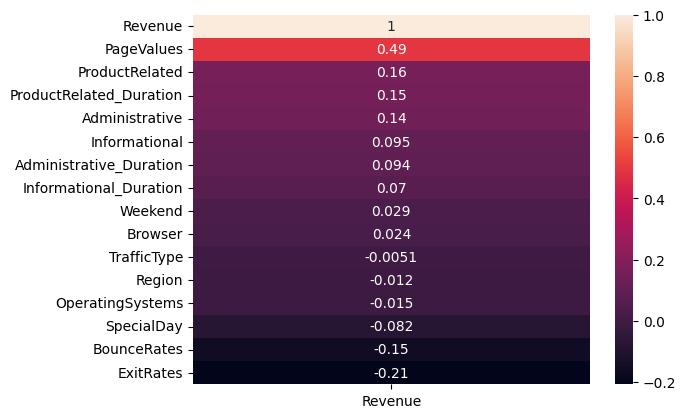

In [5]:
corr_matrix = df.corr()
# correlation between each feature and target variable
corr_df = pd.DataFrame(corr_matrix["Revenue"].sort_values(ascending=False))

# correlation using heatmap
ax = sns.heatmap(corr_df, annot=True)

### Plot Distributions

In [6]:
plt.rcParams['figure.figsize'] = [10,10]

In [7]:
continuous_var = ["Administrative", "Administrative_Duration", "Informational", "Informational_Duration", 
"ProductRelated", "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues", "SpecialDay"]

# special day has limited values so also include here
categorical_var = ['SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
'Weekend', 'Revenue']

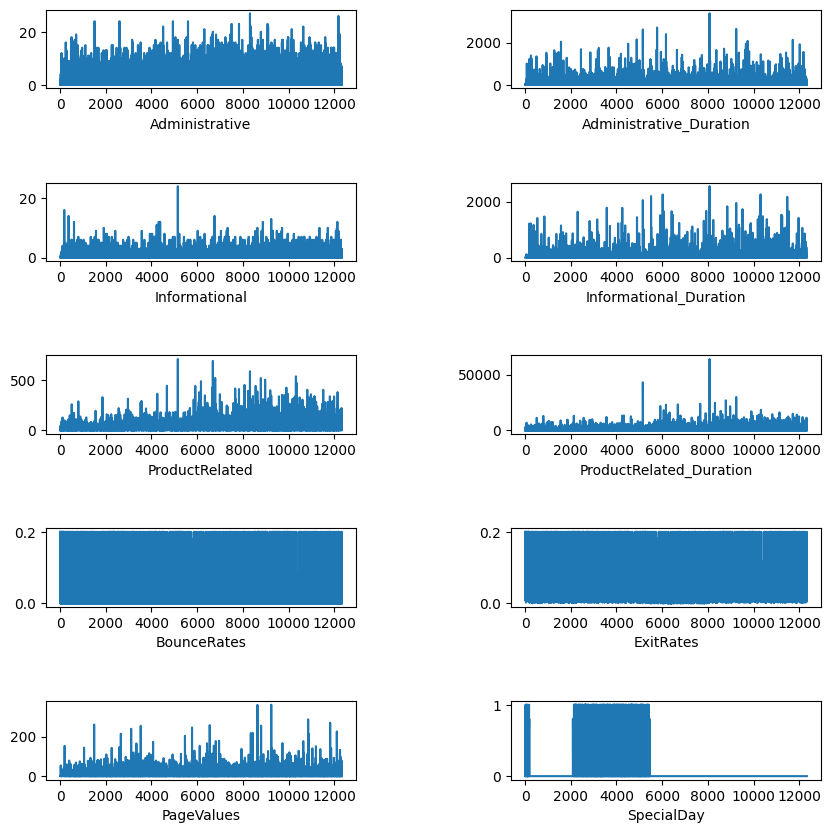

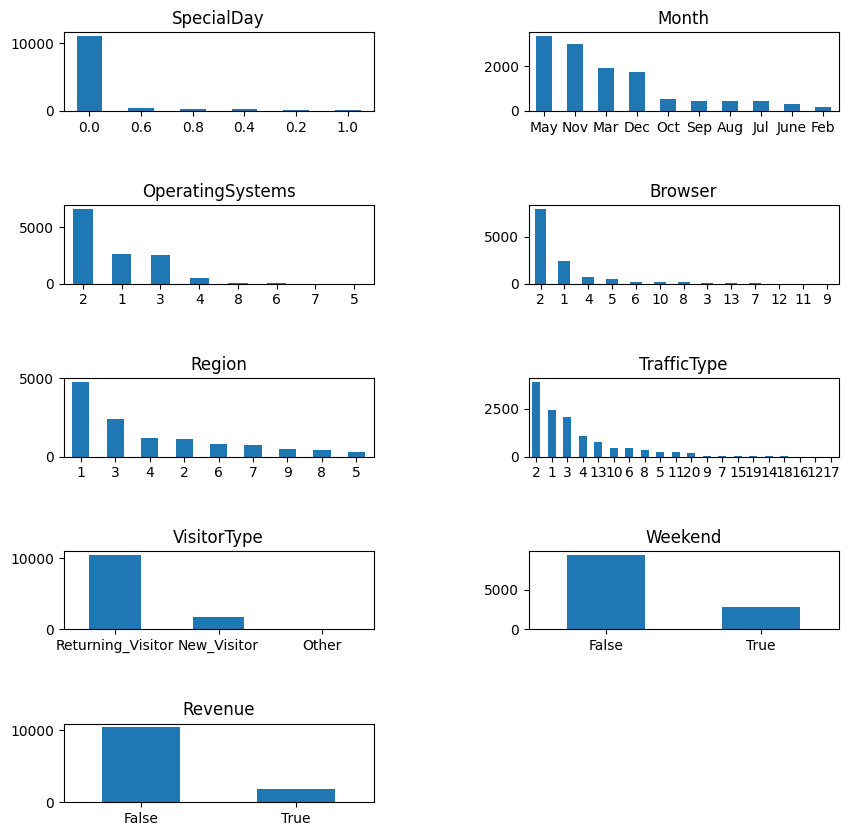

In [8]:
plot_dist(df, continuous_var)
plot_count(df, categorical_var)

### Tensorflow Extended:
- StatisticsGen component to generate statistics, schema and overall visualizations
- fix any anomalies

NOTE: tfdv treats integers as numerical features (revenue, weekend etc., as numerical) but still useful for displaying stats, validating evaluation dataset and inferring general schema

In [9]:
# split into train and test, random_state for reproducability
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0, stratify=df["Revenue"])

train_stats = tfdv.generate_statistics_from_dataframe(train_df)
tfdv.visualize_statistics(train_stats)

In [10]:
# Infer schema from the statistics.
schema = tfdv.infer_schema(statistics=train_stats)

# Display schema
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Administrative',INT,required,,-
'Administrative_Duration',FLOAT,required,,-
'Informational',INT,required,,-
'Informational_Duration',FLOAT,required,,-
'ProductRelated',INT,required,,-
'ProductRelated_Duration',FLOAT,required,,-
'BounceRates',FLOAT,required,,-
'ExitRates',FLOAT,required,,-
'PageValues',FLOAT,required,,-


,Values
Domain,
'Month',"'Aug', 'Dec', 'Feb', 'Jul', 'June', 'Mar', 'May', 'Nov', 'Oct', 'Sep'"
'VisitorType',"'New_Visitor', 'Other', 'Returning_Visitor'"


In [11]:
# Generate eval dataset statistics
eval_stats = tfdv.generate_statistics_from_dataframe(test_df)

# Compare with training
tfdv.visualize_statistics(
    lhs_statistics=eval_stats, 
    rhs_statistics=train_stats, 
    lhs_name='EVAL_DATASET', 
    rhs_name='TRAIN_DATASET'
)

In [12]:
# Check evaluation data for errors by validating the eval dataset using the original schema
anomalies =  tfdv.validate_statistics(statistics=eval_stats, schema=schema)

# Visualize anomalies
tfdv.display_anomalies(anomalies)

In [28]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Preprocessing

## Convert Categorical columns to numerical
Using one-hot encoding for high cardinality categorical attributes (like region, month etc.,) will increase the features significantly and skew the tree, so although these categories are not ordinal, use Label-encoding for these and based on the feature importance we can modify.
Use one hot encoding for others.

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [4]:
df = pd.read_csv('data/coding_round_data.csv')

# 'OperatingSystems', 'Browser', 'Region', 'TrafficType' are already label encoded 
# 'Weekend', 'Revenue' are also encoded properly
label_encode = ['Month', 'VisitorType']
#one_hot = ['VisitorType']

le = LabelEncoder()
df[label_encode] = df[label_encode].apply(lambda col: le.fit_transform(col))

#df = pd.get_dummies(df, columns = one_hot)

df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  int64  
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,1,1,1,1,2,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,2,2,2,1,2,2,False,False


In [5]:
# train test split
X_train, Y_train, X_test, Y_test = split(df, "Revenue", test_size=0.2, random_state=0, stratify=True)


Number of columns in X_train: 17, X_test: 17
Target variable name in Y_train: Revenue, Y_test: Revenue
Number of training samples: 9864, testing samples: 2466


## Feature Importance Using RF and baseline logistic regression model

In [6]:
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import RFECV

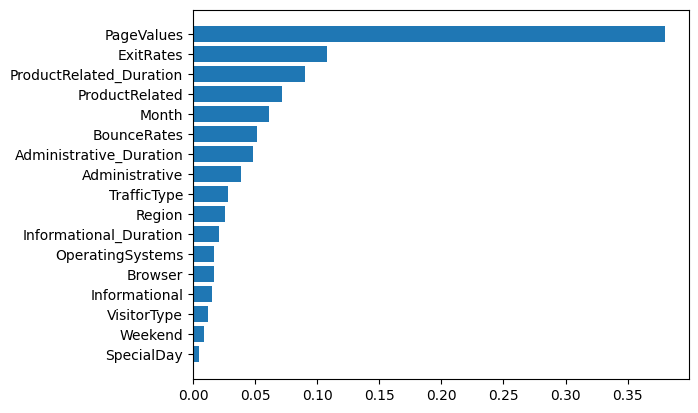

In [7]:
# by default resamples majority class (in our case where revenue is 0/false)
# other parameters can be default for now, for feature selection only
clf = BalancedRandomForestClassifier(random_state=0)
clf.fit(X_train, Y_train)

# show feature importances
fimp = list(zip(clf.feature_names_in_,clf.feature_importances_))
fimp.sort(key = lambda x : x[1])
plt.barh([x[0] for x in fimp],[x[1] for x in fimp])

plt.show()

In [38]:
print_metrics(clf, X_train, X_test, Y_train, Y_test)
pickle.dump(clf, open('models/RF_all_features', 'wb'))

Test Accuracy: 85.89%
Train Accuracy: 89.57%

Confusion matrix:
            pred:no  pred:yes
actual:no      1793       291
actual:yes       57       325

True Negatives: 1793, False Positives: 291, False negatives: 57, True positives: 325

               Class 0     Class 1
Precision     0.969189    0.527597
Recall        0.860365    0.850785
Fscore        0.911540    0.651303
Support    2084.000000  382.000000



## Logistic Regression using simple undersampling

In [8]:
# using balanced undersampled sets since LR complexity is less, smaller datasets should be fine
n = 1908
rev_1 = df[df["Revenue"]==1]
rev_0 = df[df["Revenue"]==0].sample(1908)

lr_df = pd.concat([rev_0, rev_1]) # Datframe for Logistic Regression test

train_df_lr, test_df_lr = train_test_split(lr_df, test_size=0.2, random_state=0)

X_train_lr, Y_train_lr, X_test_lr, Y_test_lr = split(lr_df, "Revenue", test_size=0.2, random_state=0)


Number of columns in X_train: 17, X_test: 17
Target variable name in Y_train: Revenue, Y_test: Revenue
Number of training samples: 3052, testing samples: 764


In [9]:
logreg = LogisticRegression()
logreg.fit(X_train_lr, Y_train_lr)

print_metrics(logreg, X_train_lr, X_test_lr, Y_train_lr, Y_test_lr)
pickle.dump(logreg, open('models/LR_balanced', 'wb'))

Test Accuracy: 81.28%
Train Accuracy: 81.29%

Confusion matrix:
            pred:no  pred:yes
actual:no       341        40
actual:yes      103       280

True Negatives: 341, False Positives: 40, False negatives: 103, True positives: 280

              Class 0     Class 1
Precision    0.768018    0.875000
Recall       0.895013    0.731070
Fscore       0.826667    0.796586
Support    381.000000  383.000000



/Users/ramyakottapalli/Desktop/Aicadium coding/aicadium_coding/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## XGBoost - Feature importance, selection, model training
- feature importance using xgboost (with handling imbalanced dataset) and selection using importance thresholds
- Use general best practice hyper-parameters for selection. Train and tune model after selecting important features
- train xgboost model with selected features and hyper-parameter tuning

In [10]:
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from numpy import sort
from sklearn.utils.class_weight import compute_sample_weight

## Feature Importance Using XGBoost

In [19]:
# for imbalanced data
# xgboost 1 is positive class = minority class
# total number of examples in the majority class divided 
# by the total number of examples in the minority class.

maj_n = Y_train.value_counts()[0] # majority samples
min_n = Y_train.value_counts()[1] # minority (where revenue is True)
scale_pos_weight = maj_n/min_n # scales the gradient for minority class

model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5, scale_pos_weight=scale_pos_weight)
model.fit(X_train, Y_train)

#save model
model.save_model('models/xgb_feature_importance.txt')

print_metrics(model, X_train, X_test, Y_train, Y_test) #plain xgboost model

Test Accuracy: 87.47%
Train Accuracy: 92.15%

Confusion matrix:
            pred:no  pred:yes
actual:no      1842       242
actual:yes       67       315

True Negatives: 1842, False Positives: 242, False negatives: 67, True positives: 315

               Class 0     Class 1
Precision     0.964903    0.565530
Recall        0.883877    0.824607
Fscore        0.922615    0.670927
Support    2084.000000  382.000000



[('PageValues', 0.45677063), ('Month', 0.12570454), ('VisitorType', 0.04447662), ('BounceRates', 0.03745079), ('ProductRelated_Duration', 0.032002274), ('ProductRelated', 0.030302105), ('Administrative_Duration', 0.029654052), ('Informational', 0.028460277), ('Administrative', 0.028084211), ('ExitRates', 0.027467547), ('SpecialDay', 0.025850315), ('Weekend', 0.025361724), ('TrafficType', 0.024541002), ('Region', 0.023580482), ('Informational_Duration', 0.022883398), ('Browser', 0.019774392), ('OperatingSystems', 0.017635684)]


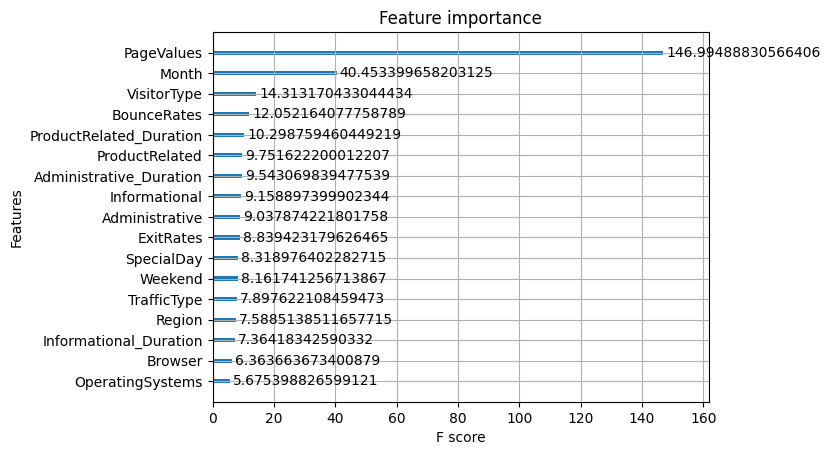

In [20]:
f_imp = zip(model.get_booster().feature_names, model.feature_importances_) # uses gain as importance type
f_imp = sorted(f_imp, key=lambda x: x[1], reverse=True)
print(f_imp)

# show feature importances
plot_importance(model, importance_type='gain')
plt.show()


## Feature Selection

In [21]:
# feature selection
""" Inputs:
        thresh: a threshold value for feature importance, any features with imp >= thresh get selected.
                trains and tests model for the subset of features selected
    Outputs:
        prints the threshold and metrics f-score
        returns the names of the selected features and the model trained on that subset
"""
def model_select(thresh):
    # select features using threshold, any feature with imp > threshold gets selected
    selected_features = [x[0] for x in f_imp if x[1] >= thresh]
    select_X_train = X_train[selected_features] 

    # train the model with feature subset
    select_model = XGBClassifier()
    select_model.fit(select_X_train, Y_train)

    # eval model, get predictions, convert to 0 or 1
    select_X_test = X_test[selected_features]
    y_pred = select_model.predict(select_X_test)

    # select threshold that performs best on fscore for class 1
    res = precision_recall_fscore_support(Y_test, y_pred)

    print("Thresh=%.3f, n=%d, F1score: %.2f%%" % (thresh, select_X_train.shape[1], res[2][1]))

    return selected_features, select_X_train, select_X_test, select_model


thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    model_select(thresh)

Thresh=0.018, n=17, F1score: 0.63%
Thresh=0.020, n=16, F1score: 0.61%
Thresh=0.023, n=15, F1score: 0.63%
Thresh=0.024, n=14, F1score: 0.61%
Thresh=0.025, n=13, F1score: 0.62%
Thresh=0.025, n=12, F1score: 0.61%
Thresh=0.026, n=11, F1score: 0.63%
Thresh=0.027, n=10, F1score: 0.62%
Thresh=0.028, n=9, F1score: 0.61%
Thresh=0.028, n=8, F1score: 0.61%
Thresh=0.030, n=7, F1score: 0.63%
Thresh=0.030, n=6, F1score: 0.62%
Thresh=0.032, n=5, F1score: 0.63%
Thresh=0.037, n=4, F1score: 0.61%
Thresh=0.044, n=3, F1score: 0.58%
Thresh=0.126, n=2, F1score: 0.58%
Thresh=0.457, n=1, F1score: 0.56%


In [22]:
# model with best f1 score -  0.63, n = 11
thresh = thresholds[6]
selected_features, select_X_train, select_X_test, selected_model = model_select(thresh)
print(selected_features)

selected_model.save_model('models/feature_selection_model.txt')

Thresh=0.026, n=11, F1score: 0.63%
['PageValues', 'Month', 'VisitorType', 'BounceRates', 'ProductRelated_Duration', 'ProductRelated', 'Administrative_Duration', 'Informational', 'Administrative', 'ExitRates', 'SpecialDay']


## Hyperparameter tuning, training and metrics

### Hyperparameter tuning
- xgboost hyperparameter truning using HYPEROPT
- define input space and objective function (model) to optimize for
- select best hyperparams

In [23]:
from functools import partial
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [33]:
LR = 0.05
n_est = 300
eval_metric = ["logloss", "auc"]
eval_set_comp = [(X_train, Y_train), (X_test, Y_test)] # complete set of features
eval_set_select = [(select_X_train, Y_train), (select_X_test, Y_test)] # with feature selection

# esr = 150 # early stopping to avoid overfitting


# define input domain space for hyperparameter search
in_space={#'LR': hp.uniform("LR", 0.01, 0.05),
        'max_depth': hp.quniform("max_depth", 3, 15, 1), # max depth of tree
        'gamma': hp.uniform ('gamma', 1,9), # Minimum loss reduction for partition
        'reg_lambda' : hp.uniform('reg_lambda', 0,1), # L2 reg 
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1), # subsample ratio of columns for each tree
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1), #child weight at which to stop partitioning
        'n_estimators': n_est,
        'seed': 0
    }

# objective function to optimize. In this case it is our model where we want to min loss/ max fscore
# takes eval set [(train), (test)] and input space of params
def obj_func(eval_set, space): #, eval_set, eval_metric):
    xtrain = eval_set[0][0]
    ytrain = eval_set[0][1]
    xtest = eval_set[1][0]
    ytest = eval_set[1][1]

    model=xgb.XGBClassifier(
                    learning_rate=LR,
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_lambda=space['reg_lambda'],
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
                    scale_pos_weight=scale_pos_weight)
    
    model.fit(xtrain, ytrain,
            eval_set=eval_set, eval_metric=eval_metric, verbose=False)
    
    y_pred = model.predict(xtest)
    y_pred = [round(value) for value in y_pred]
    res = precision_recall_fscore_support(ytest, y_pred)
    # print (f"F1score: {res[2][1]}")
    return {'loss': -res[2][1], 'status': STATUS_OK } # fmin is obj minimization so -F1score



## For model with selected features vs complete set of features
- model with feature selection seems like it can be improved fscore wise (train and test loss decreasing)
- so trying to reach close to overfit with complete features and compare precision, recall, f1score.

In [29]:
trials = Trials() # for selected features
obj_min_select = partial(obj_func, eval_set_select)
best_hp_select = fmin(fn = obj_min_select,
                space = in_space,
                algo = tpe.suggest,
                max_evals = 50,
                trials = trials)

# get best
for k, v in best_hp_select.items():
    best_hp_select[k] = float(v)

print(best_hp_select)

100%|██████████| 50/50 [01:15<00:00,  1.51s/trial, best loss: -0.6595059076262084]
{'colsample_bytree': 0.8278855810459033, 'gamma': 6.687989080530032, 'max_depth': 9.0, 'min_child_weight': 4.0, 'reg_lambda': 0.13536389292776613}


In [34]:
trials2 = Trials() # for complete features
obj_min_comp = partial(obj_func, eval_set_comp)
best_hp_comp = fmin(fn = obj_min_comp,
                space = in_space,
                algo = tpe.suggest,
                max_evals = 150, #changed to 150
                trials = trials2)

# get best
for k, v in best_hp_comp.items():
    best_hp_comp[k] = float(v)

print(best_hp_comp)

100%|██████████| 150/150 [03:36<00:00,  1.44s/trial, best loss: -0.6274509803921569]
{'colsample_bytree': 0.6788724549374365, 'gamma': 2.639868493766727, 'max_depth': 5.0, 'min_child_weight': 5.0, 'reg_lambda': 0.9372622280195063}


## Train the models using their best hyperparameters and evaluate

Test Accuracy: 87.92%
Train Accuracy: 94.14%

Confusion matrix:
            pred:no  pred:yes
actual:no      1874       210
actual:yes       88       294

True Negatives: 1874, False Positives: 210, False negatives: 88, True positives: 294

               Class 0     Class 1
Precision     0.955148    0.583333
Recall        0.899232    0.769634
Fscore        0.926347    0.663657
Support    2084.000000  382.000000

Test ROC AUC: 0.931
Test logloss: 0.277


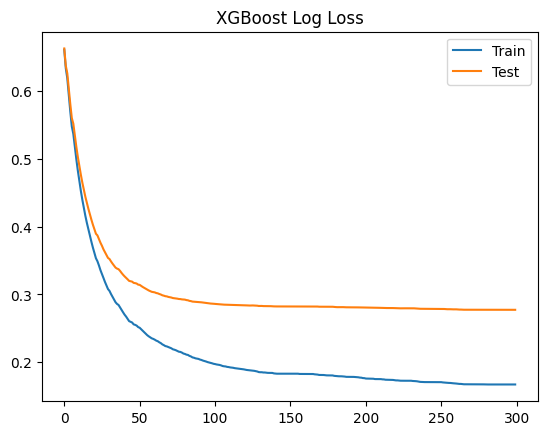

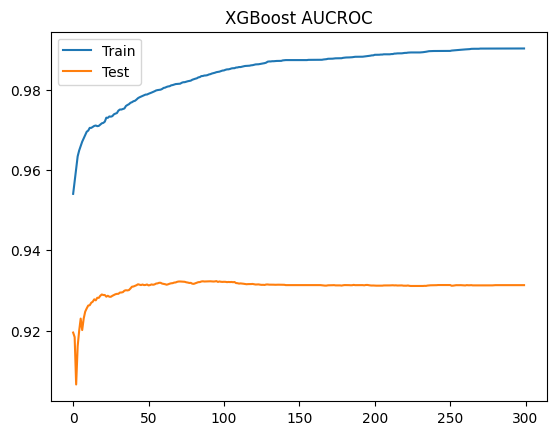

In [31]:
colsample_bytree, gamma, max_depth, min_child_weight, reg_lambda = best_hp_select.values()

model_select = XGBClassifier(learning_rate=LR, n_estimators=n_est, 
    max_depth=int(max_depth), scale_pos_weight=scale_pos_weight,
    colsample_bytree=colsample_bytree,
    gamma=gamma,
    min_child_weight=min_child_weight,
    reg_lambda=reg_lambda)

model_select.fit(select_X_train, Y_train, eval_metric=eval_metric, eval_set=eval_set_select, verbose=False)

model_select.save_model('models/final_model_selected_features.txt')

print_metrics(model_select, select_X_train, select_X_test, Y_train, Y_test)
plot_metrics(model_select)

Test Accuracy: 87.63%
Train Accuracy: 90.99%

Confusion matrix:
            pred:no  pred:yes
actual:no      1844       240
actual:yes       65       317

True Negatives: 1844, False Positives: 240, False negatives: 65, True positives: 317

               Class 0     Class 1
Precision     0.965951    0.569120
Recall        0.884837    0.829843
Fscore        0.923616    0.675186
Support    2084.000000  382.000000

Test ROC AUC: 0.935
Test logloss: 0.293


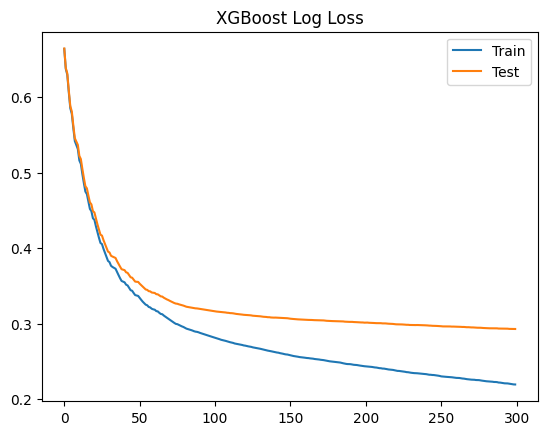

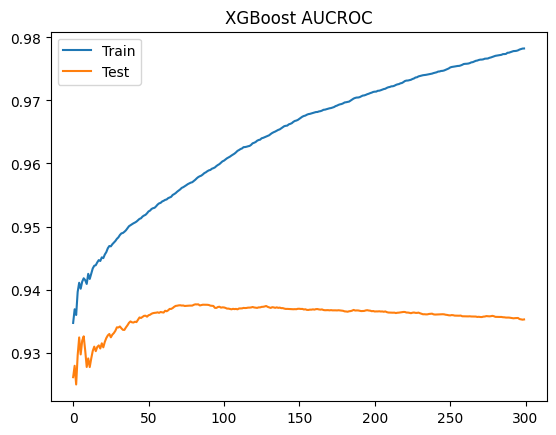

In [35]:
# model with no feature selection, hyperopt used
colsample_bytree, gamma, max_depth, min_child_weight, reg_lambda = best_hp_comp.values()

model_comp = XGBClassifier(learning_rate=LR, n_estimators=n_est, 
    max_depth=int(max_depth), scale_pos_weight=scale_pos_weight,
    colsample_bytree=colsample_bytree,
    gamma=gamma,
    min_child_weight=min_child_weight,
    reg_lambda=reg_lambda)

model_comp.fit(X_train, Y_train, eval_metric=eval_metric, eval_set=eval_set_comp, verbose=False)

model_comp.save_model('models/final_model_all_features.txt')

print_metrics(model_comp, X_train, X_test, Y_train, Y_test)
plot_metrics(model_comp)